In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import pathlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("datasets/wv_3d/df.csv")
features = ["head size","body size"]

In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(df[features],df['label'])


In [4]:
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
b = -b/w2
w = -w1/w2

In [17]:
b,w = 1.5,-2

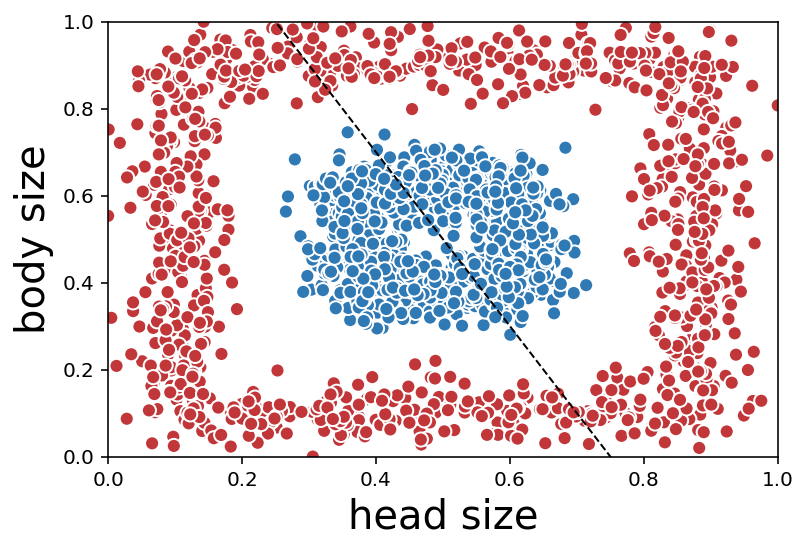

In [18]:
xd = np.array([0, 1])
yd = w*xd + b
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.scatter(df[features[0]],df[features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.show()

In [19]:
def return_label(w,b,x,y):
    y_prime = w*x+b
    if y>y_prime:
        return 1
    else:
        return 0
df['pseudo_label'] = df.apply(lambda row : return_label(w,b,row[features[0]],row[features[1]]), axis = 1)


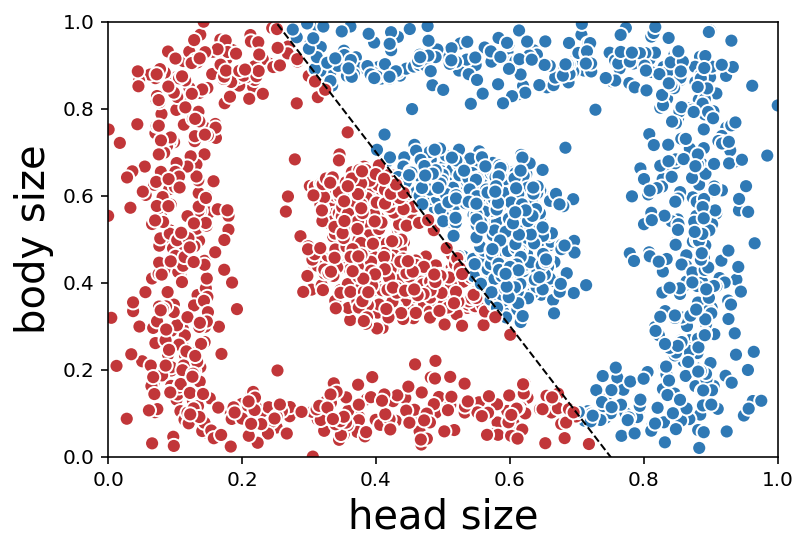

In [20]:
xd = np.array([0, 1])
yd = w*xd + b
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.scatter(df[features[0]],df[features[1]], c=df["pseudo_label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.show()

In [21]:
total = np.arange(len(df))
valid = np.random.choice(total, 400, replace=False)
total = np.setdiff1d(total, valid)
test = np.random.choice(total, 400, replace=False)
total = np.setdiff1d(total, test)
train = total

In [22]:
train_df = df.iloc[train]
valid_df = df.iloc[valid]
test_df = df.iloc[test]

In [25]:
raw_data = "datasets/wv_3d/raw_imgs"
dir = "datasets/wv_3d/pseudo_label"
split = "valid"
for i in range(len(valid_df)):
    row = valid_df.iloc[i]
    label = row["pseudo_label"]
    src = os.path.join(raw_data,row["img_id"])
    dst = os.path.join(dir,split,str(label))
    shutil.copy(src,dst)

## synthetic features.pkl

In [26]:
# df = pd.read_csv("datasets/wv_3d/df.csv")
features = ["head size","body size","tail size","texture"]

In [27]:
files = utils.dataset_filenames("datasets/wv_3d/pseudo_label/train")
files = [x.split("/")[-1] for x in files[:,0]]
train_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [28]:
files = utils.dataset_filenames("datasets/wv_3d/pseudo_label/valid")
files = [x.split("/")[-1] for x in files[:,0]]
valid_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [29]:
files = utils.dataset_filenames("datasets/wv_3d/pseudo_label/test")
files = [x.split("/")[-1] for x in files[:,0]]
test_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [30]:
pickle.dump(train_features, open("datasets/wv_3d/pseudo_label/train_features.pkl","wb"))
pickle.dump(valid_features, open("datasets/wv_3d/pseudo_label/valid_features.pkl","wb"))
pickle.dump(test_features, open("datasets/wv_3d/pseudo_label/test_features.pkl","wb"))

### triplet gen

In [31]:
train_features = pickle.load(open("datasets/wv_3d/pseudo_label/train_features.pkl","rb"))
valid_features = pickle.load(open("datasets/wv_3d/pseudo_label/valid_features.pkl","rb"))
test_features = pickle.load(open("datasets/wv_3d/pseudo_label/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/pseudo_label/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/pseudo_label/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/pseudo_label/test")])

#### aligns & filtered

In [32]:
weights = [
    [0,0,1,1],
    [0,1,1,1],
    [1,0,1,1],
    [1,1,1,1],
    [1,1,0,0]
]
aligns = [0.5,0.55,0.85,0.95,0.985]
total = 30000
triplet_dir = "datasets/wv_3d_linear_triplets"

In [33]:

for weight,align in zip(weights, aligns):
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    pathlib.Path(align_dir).mkdir(parents=True, exist_ok=True)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.7471666666666666 0.7446666666666667 0.7415
0.7575555555555555 0.7466666666666667 0.7578333333333334
0.8071666666666667 0.8001666666666667 0.8055
0.8002777777777778 0.7918333333333333 0.7953333333333333
0.8595 0.8616666666666667 0.859


### noisy

In [35]:
train_triplets = pickle.load(open(f"{triplet_dir}/align=0.55/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open(f"{triplet_dir}/align=0.55/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open(f"{triplet_dir}/align=0.55/test_triplets.pkl","rb"))
for p in [0.05,0.1, 0.25, 0.5]:
    dir = os.path.join(f"{triplet_dir}/align=0.55_noisy",str(p))
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

    train_noisy = gen.get_noisy_triplets(train_triplets, p)
    valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
    test_noisy = gen.get_noisy_triplets(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [36]:
train_triplets = pickle.load(open(f"{triplet_dir}/align=0.85/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open(f"{triplet_dir}/align=0.85/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open(f"{triplet_dir}/align=0.85/test_triplets.pkl","rb"))
for p in [0.05,0.1, 0.25, 0.5]:
    dir = os.path.join(f"{triplet_dir}/align=0.85_noisy",str(p))
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

    train_noisy = gen.get_noisy_triplets(train_triplets, p)
    valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
    test_noisy = gen.get_noisy_triplets(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

### nums

In [37]:
def dropout(triplets,p):
    keepers = np.random.choice(np.arange(len(triplets)),int(len(triplets)*p),replace=False)
    return np.array(triplets)[keepers]

In [38]:
train_triplets = pickle.load(open(f"{triplet_dir}/align=0.55/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open(f"{triplet_dir}/align=0.55/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open(f"{triplet_dir}/align=0.55/test_triplets.pkl","rb"))
for p in [1/8,1/4,1/2]:
    dir = os.path.join(f"{triplet_dir}/align=0.55_num",str(p))
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

    train_noisy = dropout(train_triplets, p)
    valid_noisy = dropout(valid_triplets, p)
    test_noisy = dropout(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [39]:
train_triplets = pickle.load(open(f"{triplet_dir}/align=0.85/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open(f"{triplet_dir}/align=0.85/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open(f"{triplet_dir}/align=0.85/test_triplets.pkl","rb"))
for p in [1/8,1/4,1/2]:
    dir = os.path.join(f"{triplet_dir}/align=0.85_num",str(p))
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

    train_noisy = dropout(train_triplets, p)
    valid_noisy = dropout(valid_triplets, p)
    test_noisy = dropout(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [40]:
weights = [
    [0,1,1,1],
    [1,0,1,1]
]
aligns = [0.55,0.85]
total = 30000*2
for weight,align in zip(weights, aligns):
    dir = f"{triplet_dir}/align={align}_num/2"
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weight, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))


    pickle.dump(train_triplets, open(f"{dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{dir}/test_triplets.pkl", "wb"))

0.7593055555555556 0.7595833333333334 0.7568964080340028
0.7959387760771133 0.8035833333333333 0.8001666666666667


## yaml generation

In [41]:
weights = [
    [0,0,1,1],
    [0,1,1,1],
    [1,0,1,1],
    [1,1,1,1],
    [1,1,0,0]
]
aligns = [0.5,0.55,0.85,0.95,0.985]

In [44]:
yaml_dir = "models/configs/wv_3d/linear/align_triplets"
base = oc.load(f"{yaml_dir}/align=0.5.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base.train_triplets.replace("0.5",str(align))
    valid_triplets = base.valid_triplets.replace("0.5",str(align))
    test_triplets = base.test_triplets.replace("0.5",str(align))
    wandb_group = base.wandb_group.replace("0.5",str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"{yaml_dir}/align={align}.yaml")

In [45]:
base_filtered = oc.load(f"{yaml_dir}/align=0.5_filtered.yaml")
for weight,align in zip(weights, aligns):
    train_triplets = base_filtered.train_triplets.replace("0.5",str(align))
    valid_triplets = base_filtered.valid_triplets.replace("0.5",str(align))
    test_triplets = base_filtered.test_triplets.replace("0.5",str(align))
    wandb_group = base_filtered.wandb_group.replace("0.5",str(align))
    overwrite = {"weights":weight, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_filtered,overwrite), f"{yaml_dir}/align={align}_filtered.yaml")

In [46]:
yaml_dir = "models/configs/wv_3d/linear/noisy_0.55"
base_noisy = oc.load(f"{yaml_dir}/p=0.05.yaml")
for p in [0.05,0.1,0.25,0.5]:
    train_triplets = base_noisy.train_triplets.replace("0.05",str(p))
    valid_triplets = base_noisy.valid_triplets.replace("0.05",str(p))
    test_triplets = base_noisy.test_triplets.replace("0.05",str(p))
    wandb_group = base_noisy.wandb_group.replace("0.05",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_noisy,overwrite), f"{yaml_dir}/p={p}.yaml")

In [47]:
yaml_dir = "models/configs/wv_3d/linear/noisy_0.85"
base_noisy = oc.load(f"{yaml_dir}/p=0.05.yaml")
for p in [0.05,0.1,0.25,0.5]:
    train_triplets = base_noisy.train_triplets.replace("0.05",str(p))
    valid_triplets = base_noisy.valid_triplets.replace("0.05",str(p))
    test_triplets = base_noisy.test_triplets.replace("0.05",str(p))
    wandb_group = base_noisy.wandb_group.replace("0.05",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_noisy,overwrite), f"{yaml_dir}/p={p}.yaml")

In [48]:
yaml_dir = "models/configs/wv_3d/linear/num_0.55"
base_num = oc.load(f"{yaml_dir}/p=0.5.yaml")
for p in [0.5,0.25,0.125,2]:
    train_triplets = base_num.train_triplets.replace("0.5",str(p))
    valid_triplets = base_num.valid_triplets.replace("0.5",str(p))
    test_triplets = base_num.test_triplets.replace("0.5",str(p))
    wandb_group = base_num.wandb_group.replace("0.5",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_num,overwrite), f"{yaml_dir}/p={p}.yaml")

In [49]:
yaml_dir = "models/configs/wv_3d/linear/num_0.85"
base_num = oc.load(f"{yaml_dir}/p=0.5.yaml")
for p in [0.5,0.25,0.125,2]:
    train_triplets = base_num.train_triplets.replace("0.5",str(p))
    valid_triplets = base_num.valid_triplets.replace("0.5",str(p))
    test_triplets = base_num.test_triplets.replace("0.5",str(p))
    wandb_group = base_num.wandb_group.replace("0.5",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_num,overwrite), f"{yaml_dir}/p={p}.yaml")